# Deep Dreaming on Audio Spectrograms with Tensorflow 2.x

In [1]:
! pip install tensorflow>=2.0.0 pillow numpy matplotlib librosa soundfile

In [2]:

"""
This notebook is a TensorFlow 2.x adaptation of the original deep_audio_dreams.ipynb.
It uses TensorFlow 2.x to create "Deep Dream" effects on audio spectrograms.
"""

import os
import numpy as np
from io import BytesIO
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import IPython.display
import tensorflow as tf
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()  # We still need some TF1.x compatibility for the inception model
import librosa
import matplotlib.pyplot as plt



Instructions for updating:
non-resource variables are not supported in the long term


# Run this cell only if you do not have the inception model graph


In [3]:
from io import BytesIO
import requests, zipfile, os

# Download the pretrained (on imagenet) inception weights
url = "https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip"
local_zip_file = "inception5h.zip"

# Download the file
response = requests.get(url)
with open(local_zip_file, 'wb') as f:
    f.write(response.content)

# Unzip the file
with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
    zip_ref.extractall()

# Clean up the zip file
os.remove(local_zip_file)

# Helper function to display arrays as images

In [3]:
def showarray(a, fmt='jpeg'):
    # Convert tensor to numpy if needed
    if isinstance(a, tf.Tensor):
        a = a.numpy() if tf.executing_eagerly() else sess.run(a)
    
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

In [4]:
# Load the pretrained model
def load_inception_model():
    model_fn = '../Inception_graph/tensorflow_inception_graph.pb'
    graph = tf1.Graph()
    sess = tf1.InteractiveSession(graph=graph)
    with tf.io.gfile.GFile(model_fn, 'rb') as f:
        graph_def = tf1.GraphDef()
        graph_def.ParseFromString(f.read())
    t_input = tf1.placeholder(np.float32, name='input')
    imagenet_mean = 117.0
    t_preprocessed = tf1.expand_dims(t_input-imagenet_mean, 0)
    tf1.import_graph_def(graph_def, {'input': t_preprocessed})
    return graph, sess, t_input

# Initialize model
graph, sess, t_input = load_inception_model()

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name(f"import/{layer}:0")



def calc_grad_tiled(img, t_grad, tile_size=512):
    sz = tile_size
    
    # First, ensure img is a numpy array
    if isinstance(img, tf.Tensor):
        img = img.numpy() if tf.executing_eagerly() else sess.run(img)
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    
    # Convert to tensor and evaluate using session
    img_tf = tf.convert_to_tensor(img)
    
    img_shift = tf.roll(tf.roll(img_tf, shift=sx, axis=1), shift=sy, axis=0)
    img_shift_np = sess.run(img_shift)  # Convert back to numpy
    
    # Initialize grad as numpy array
    grad = np.zeros(img.shape, dtype=img.dtype)
    
    # Use original tiling strategy
    for y in range(0, max(h-sz//2, sz), sz):
        for x in range(0, max(w-sz//2, sz), sz):
            y_end = min(y + sz, h)
            x_end = min(x + sz, w)
            
            sub = img_shift_np[y:y_end, x:x_end]
            g = sess.run(t_grad, {t_input: sub})
            
            # Handle potential size mismatch
            g_h, g_w = g.shape[:2]
            grad[y:y+g_h, x:x+g_w] = g
    
    # Convert to tensor only when needed for the roll operations
    grad_tf = tf.convert_to_tensor(grad)
    grad_shifted = tf.roll(tf.roll(grad_tf, shift=-sx, axis=1), shift=-sy, axis=0)
    return sess.run(grad_shifted)


# Laplacian Pyramid utilities
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    with tf1.name_scope('split'):
        lo = tf1.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf1.nn.conv2d_transpose(lo, k5x5*4, tf1.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    img = levels[0]
    for hi in levels[1:]:
        with tf1.name_scope('merge'):
            img = tf1.nn.conv2d_transpose(img, k5x5*4, tf1.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    with tf1.name_scope('normalize'):
        std = tf1.sqrt(tf1.reduce_mean(tf1.square(img)))
        return img/tf1.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    img = tf1.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

# Deep Dream implementation

In [8]:
# Wrting the DeepDream function 
def render_deepdream(t_obj, img0, iter_n=15, step=1.5, octave_n=8, octave_scale=1.4):
    t_obj_scaled = tf1.multiply(t_obj, tf1.cast(tf1.math.log(t_obj) < 0.8*tf1.reduce_max(t_obj), tf.float32))
    t_score = tf1.reduce_mean(t_obj_scaled)
    t_grad = tf1.gradients(t_score, t_input)[0]
    
    img = img0.copy()
    octaves = []
    
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = tf.image.resize(img[np.newaxis], np.int32(np.float32(hw)/octave_scale))[0]
        hi = img-tf.image.resize(lo[np.newaxis], hw)[0]
        img = lo
        octaves.append(hi)
    
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = tf.image.resize(img[np.newaxis], hi.shape[:2])[0] + hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # Convert g to numpy if it's a tensor
            if isinstance(g, tf.Tensor):
                g = g.numpy() if tf.executing_eagerly() else sess.run(g)
            # Convert img to numpy if it's a tensor
            if isinstance(img, tf.Tensor):
                img = img.numpy() if tf.executing_eagerly() else sess.run(img)
            
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.', end=' ')
        clear_output()
        # Ensure img is numpy array before passing to showarray
        if isinstance(img, tf.Tensor):
            img = img.numpy() if tf.executing_eagerly() else sess.run(img)
        showarray(img/255.0)
    return img/255.0

# Audio processing functions
def process_audio(audio_path, sr=44100):
    # Load audio
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Compute STFT
    nfft = 2048
    hop = 256
    y_stft = librosa.stft(y, n_fft=nfft, hop_length=hop, center=True)
    
    # Separate magnitude and phase
    y_stft_mag, y_stft_ang = librosa.magphase(y_stft)
    
    # Scale spectrogram
    nonlin = 1.0/8.0
    y_stft_mag_scaled = np.power(y_stft_mag, nonlin)
    y_stft_mag_scaled = np.flipud((1 - y_stft_mag_scaled/y_stft_mag_scaled.max()))
    
    # Convert to RGB
    y_stft_mag_rgb = np.stack([y_stft_mag_scaled]*3, axis=-1)
    img = 255 * y_stft_mag_rgb
    
    return img, y_stft_mag, y_stft_ang, sr

def resynthesize_audio(dream_spec, original_mag, original_ang, sr=44100):
    # Undo processing
    deepdream_out = np.flipud(dream_spec)
    deepdream_out = (1 - deepdream_out) * original_mag.max()
    deepdream_out = np.power(deepdream_out, 1/0.125)  # 1/8.0
    deepdream_out = np.sum(deepdream_out, axis=2) / 3.0
    
    # Add phase back
    deepdream_out = deepdream_out * original_ang
    
    # Inverse STFT
    output = librosa.istft(deepdream_out, hop_length=256, win_length=2048, center=True)
    
    return output


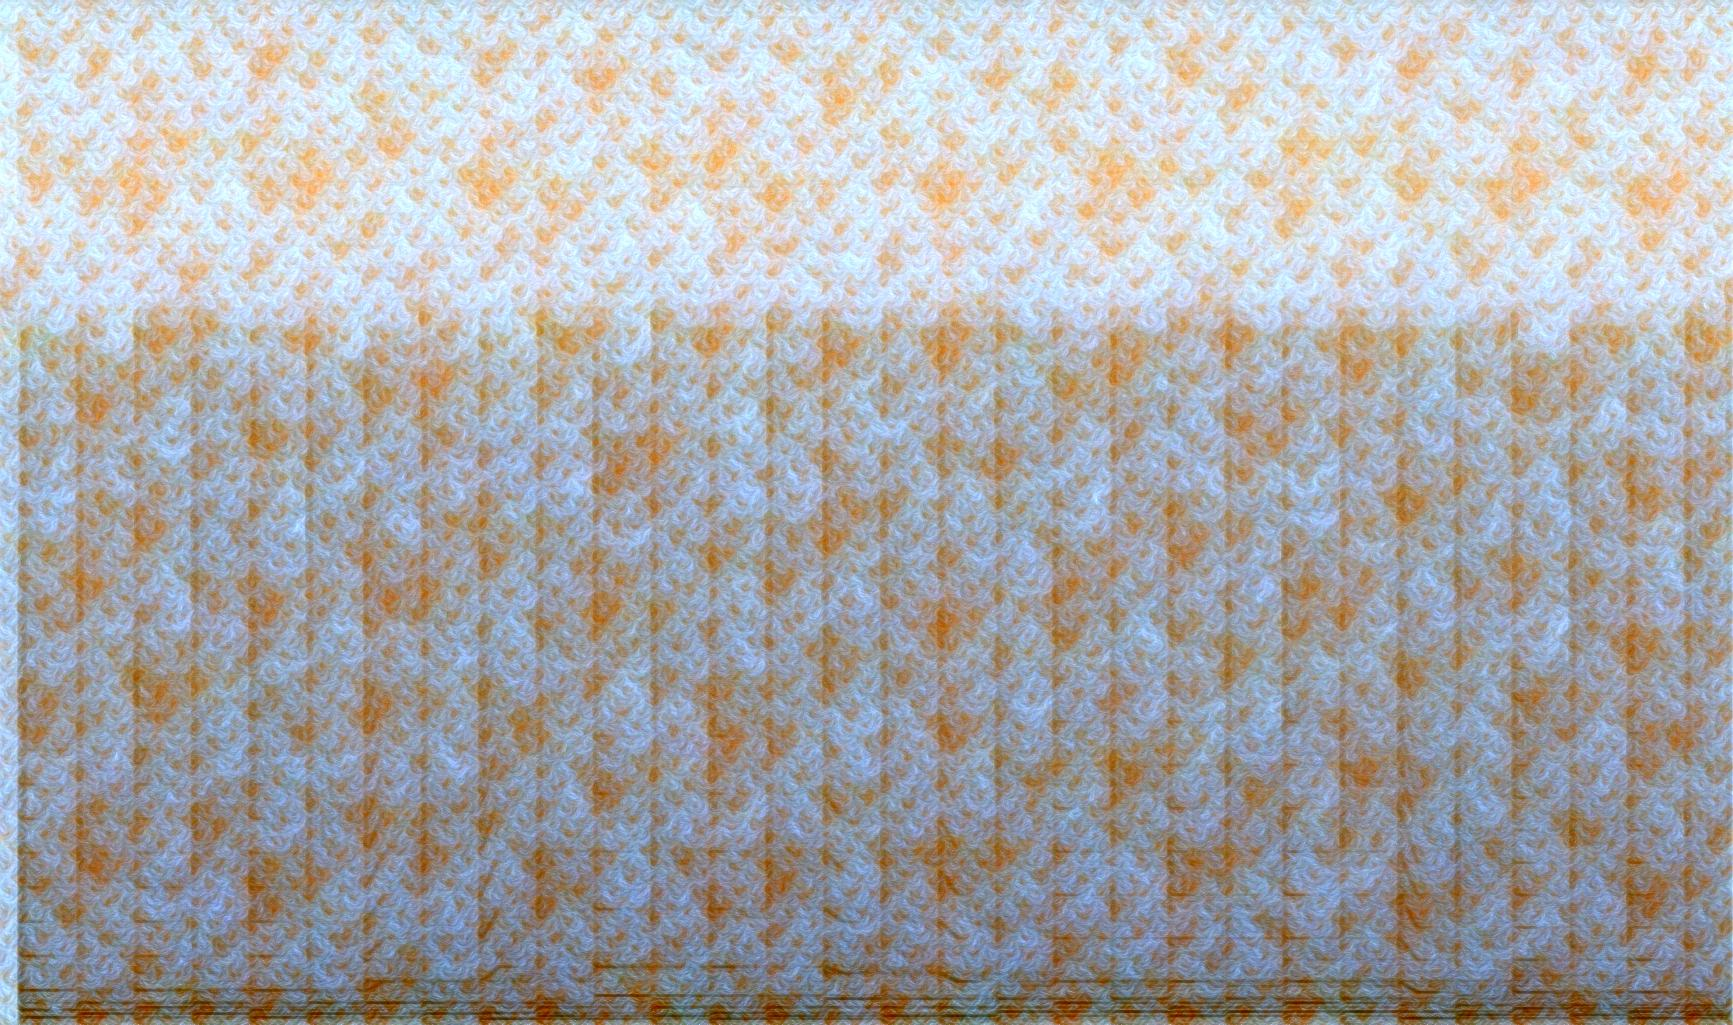

In [13]:
import soundfile as sf

if __name__ == "__main__":
    # Load and process audio
    audio_path = '../audio/fade.mp3'
    img, orig_mag, orig_ang, sr = process_audio(audio_path)
    
    # Show original spectrogram      
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(np.log(orig_mag), sr=sr, x_axis='time', y_axis='log')
    plt.title('Original Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    
    # Apply deep dream
    layer = 'mixed3b_1x1_pre_relu'
    channel = 59
    dream_spec = render_deepdream(T(layer)[:,:,:,channel], img)
    
    # Resynthesize audio
    output = resynthesize_audio(dream_spec, orig_mag, orig_ang, sr)
    
    # Play the result
    IPython.display.Audio(data=output, rate=sr)
    
    # Save the result
    sf.write('../audio/outputs/fade_dreamed.wav', output, sr)


In [14]:
# Play the result
IPython.display.Audio(data=output, rate=sr)